In [9]:
import numpy as np
import pandas as pd
import _pickle as cPickle
import os
import torch
import seaborn as sns

from game import TinyHintGuessGame
from agent import QAgent

In [10]:
# append results to list

model_name = 'ActionIn-sin-1-5-3'

res_list = []
for res_folder in list(os.walk('../res'))[0][1]:
    if res_folder.startswith(model_name):
        with open(f'../res/{res_folder}/300.pkl', 'rb') as fp:
            res = cPickle.load(fp)
            res_list.append(res)

In [12]:
print(res_list)

[{'p1': <agent.QAgent object at 0x7ff0d42e9fd0>, 'p2': <agent.QAgent object at 0x7ff0d42b2b90>}, {'p1': <agent.QAgent object at 0x7ff100413350>, 'p2': <agent.QAgent object at 0x7ff100841310>}]


In [13]:
def sample_games(hinter, guesser, samples=100, print_games=False, env=None):
    r_list = []
    if not env:
        env = hinter.env
    for i_episode in range(samples):
        obs_to_hinter = env.reset()
        hint_action = hinter.select_action(torch.tensor(obs_to_hinter, device=hinter.device))
        obs_to_guesser, _, _, _ = env.step(hint_action.item())
        guess_action = guesser.select_action(torch.tensor(obs_to_guesser, device=hinter.device))
        _, r, _, _ = env.step(guess_action)
        r_list += [r]
        if print_games:
            print(env.h1, env.h2, env.target, env.hint, r)
    r_list = np.array(r_list)
    return np.sum(np.array(r_list) >= 0, axis=0) / r_list.shape[0]
    
def cross_play(res_list, samples=100):
    group_size = len(res_list)
    score_array = np.zeros((group_size, group_size))
    for i in range(group_size):
        for j in range(group_size):
            p1 = res_list[i]['p1']
            p2 = res_list[j]['p2']
            score_array[i][j] = sample_games(p1, p2, samples = samples)
    return score_array

In [14]:
%%time
score_array = cross_play(res_list, samples=100)

CPU times: user 900 ms, sys: 39.4 ms, total: 939 ms
Wall time: 931 ms


In [15]:
np.savetxt(f"../{model_name}.csv", score_array, delimiter=",")

<AxesSubplot:>

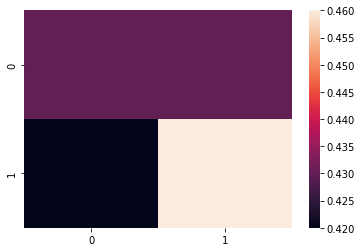

In [16]:
sns.heatmap(score_array)

In [17]:
sample_games(res_list[0]['p1'], res_list[1]['p1'], samples=20, print_games=True)

[2 0 4] [1 3 3] 3 0 10.0
[3 2 0] [1 4 3] 3 0 -10.0
[3 2 3] [4 2 1] 4 3 10.0
[4 4 0] [4 0 0] 0 4 -10.0
[0 1 4] [0 1 2] 1 4 -10.0
[2 3 1] [0 1 3] 3 3 10.0
[0 1 3] [2 4 3] 3 0 10.0
[0 2 4] [2 1 4] 4 0 -10.0
[1 4 1] [4 4 3] 3 1 -10.0
[2 3 2] [1 0 0] 0 2 -10.0
[0 3 0] [3 4 3] 3 0 10.0
[2 4 3] [0 4 2] 4 3 10.0
[4 4 3] [2 1 4] 2 4 10.0
[3 3 0] [3 2 4] 2 3 -10.0
[0 0 4] [2 4 4] 2 0 -10.0
[4 4 2] [3 2 2] 2 4 10.0
[0 0 1] [3 0 3] 3 0 10.0
[0 0 0] [2 4 0] 2 0 10.0
[0 2 1] [4 3 3] 3 1 10.0
[3 4 3] [2 2 1] 1 4 -10.0


0.55